# Toy problem : some kind of simple differentiable programming with Pytorch

Author: Charles Le Losq, Australian National University, 2019.

In this problem, we want a neural network to predict the parameter of a function that allows calculation of the $y$ observations.

We will use Torch in Python to approach this problem in this notebook.

See also the version using Julia + Flux.jl for a side to side comparison.

In [24]:
# Library loading
%matplotlib inline

import pandas as pd # manipulate dataframes
import matplotlib.pyplot as plt # plotting
import matplotlib
import numpy as np
import torch, time

from sklearn.metrics import mean_squared_error

#np.random.seed(42) # fixing random seed

# The problem

$y$ depends on $x1$ and $x2$ via the equation

$y = A + \frac{B}{x2} + C\times cos(x2./D)$   eq. 1

with $A$, $B$ $C$, and $D = f(x1)$ and $f$ unknown. Here we will generate a toy dataset with a simple $f$ and $x1$ with 1 feature, but in reality $f$ is a stronly non-linear function and inputs $x1$ have multiple features.

Dataset size is (30000, 1)


/home/charles/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':


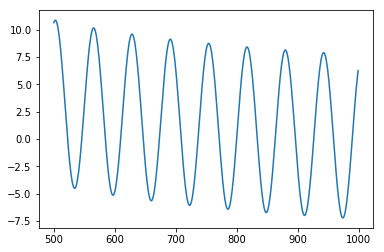

In [26]:
def model(x2,A,B,C,D): # this is eq. 1
    return A + B/x2 + C*np.cos(x2/D)

# here we assume we know how A, B and C vary with x1
def fake_eq0(x1):
    A = -3.0 # constant
    B = 40000.0*0.1*x1
    C = np.abs(0.5 - x1*10.)
    D = 10.0
    return A, B, C, D

x1 = np.around(np.arange(0.4,1.0,0.01,dtype='Float64'),2)
x2 = np.arange(500.0,1000.0,1.0)

A_fake, B_fake, C_fake, D_fake = fake_eq0(x1)

# we buyild our training set
for i in range(0,len(B_fake)):
    if i == 0:
        X1_training = np.ones(len(x2))*x1[i]
        X2_training = x2
        y_training = model(x2,A_fake,B_fake[i],C_fake[i],D_fake)
    else:
        X1_training = np.hstack((X1_training,np.ones(len(x2))*x1[i]))
        X2_training = np.hstack((X2_training,x2))
        y_training = np.hstack((y_training,model(x2,A_fake,B_fake[i],C_fake[i],D_fake)))

X1_training = X1_training.reshape(-1,1)        
X2_training = X2_training.reshape(-1,1)        
y_training = y_training.reshape(-1,1)        

plt.plot(x2,y_training[X1_training==0.8]) # for one x1, we have a nice variation described by eq.1

print("Dataset size is", X1_training.shape)

# Solving the problem: 

Combine neural net to predict B and C, we also know that A and D are constant so we solve them at the same time, and then use this in eq .1 to predict our observations.

In [27]:
class Feedforward(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Feedforward, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.relu = torch.nn.ReLU()

        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)        
        self.fc2 = torch.nn.Linear(self.hidden_size, self.hidden_size)
        self.out = torch.nn.Linear(self.hidden_size, 2)

        # now declaring variables for A and D
        self.A = torch.nn.Parameter(data=torch.tensor([-1.0]))
        self.D = torch.nn.Parameter(data=torch.tensor([-1.0]))
    
    def eq1(self,x2): # this is eq. 1
        return self.A + self.B/x2 + self.C*torch.cos(x2/self.D)
    
    def output_bias_init(self):
        self.out.bias = torch.nn.Parameter(data=torch.tensor([np.log(1000.),np.log(10.)]))
    
    def forward(self, x1, x2):
        hidden1 = self.fc1(x1)
        relu1 = self.relu(hidden1)
        hidden2 = self.fc2(relu1)
        relu2 = self.relu(hidden2)
        output = self.out(relu2)
        
        # extract parameters from network
        self.B = torch.exp(output[:,0])
        self.C = torch.exp(output[:,1])
        
        # need to reshape things
        self.B = torch.reshape(self.B, (self.B.shape[0], 1))
        self.C = torch.reshape(self.C, (self.C.shape[0], 1))
        
        return self.eq1(x2)

# put our data in Torch objects
x1_train = torch.FloatTensor(X1_training)
x2_train = torch.FloatTensor(X2_training)
y_train = torch.FloatTensor(y_training)

# create network
nb_neurons = 100
neuralmodel = Feedforward(1,nb_neurons)

In [28]:
# criterion for match
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(neuralmodel.parameters(), lr = 0.001) # optimizer

# we initialize the output bias
neuralmodel.output_bias_init()

# To see how the model is improving, 
# we can check the test loss before the model training and compare it with the test loss after the training.
neuralmodel.eval()
y_pred = neuralmodel(x1_train, x2_train)
before_train = criterion(y_pred, y_train)
print('Test loss before training' , before_train.item())

Test loss before training 74.8465805053711


In [29]:
time1 = time.time()
neuralmodel.train()
epoch = 100
record_loss = np.zeros(epoch)

for epoch in range(epoch):

    optimizer.zero_grad()

    # Forward pass
    y_pred = neuralmodel(x1_train, x2_train)

    # Compute Loss
    loss = criterion(y_pred, y_train)
    record_loss[epoch] = loss
   
    #print('Epoch {}: train loss: {}'.format(epoch, loss.item()))
    # Backward pass
    loss.backward()
    optimizer.step()
    
time2 = time.time()

print("Running time in seconds:", time2-time1)

Running time in seconds: 4.655728340148926


In [30]:
neuralmodel.eval()
y_pred = neuralmodel(x1_train, x2_train)
after_train = criterion(y_pred.squeeze(), y_train) 
print('Test loss after Training' , after_train.item())

/home/charles/miniconda3/envs/py36/lib/python3.6/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([30000, 1])) that is different to the input size (torch.Size([30000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test loss after Training 24.605274200439453


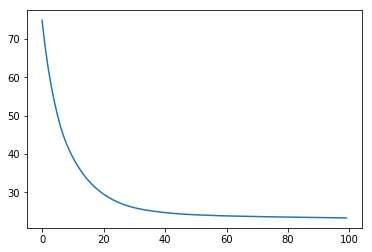

In [31]:
plt.plot(record_loss)

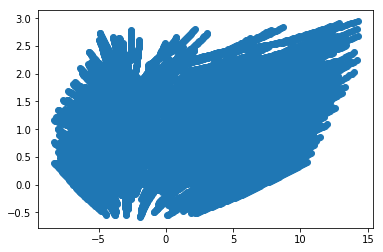

In [32]:
plt.scatter(y_train,y_pred.detach().numpy())#,xlabel="Measurements", ylabel="Predictions")